In [48]:
import pandas as pd
import numpy as np
import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

pd.set_option("max_rows", 200)
pd.set_option("max_columns", 50)
tqdm.tqdm.pandas()
%matplotlib inline

In [49]:
df = pd.read_pickle("../input/riiid-test-answer-prediction/split10/train_0.pickle").sort_values(["user_id", "timestamp"]).reset_index(drop=True)

In [50]:
import sys
sys.path.append("../")
# df = pd.read_pickle("../input/riiid-test-answer-prediction/split10/train_0.pickle")
df = df.sort_values(["user_id", "timestamp"])
# large_user_id = df["user_id"].value_counts()
# large_user_id = large_user_id[large_user_id > 1000] 
# df = df[df["user_id"].isin(large_user_id.index)]
# df = df[df["answered_correctly"] != -1]

In [51]:
df["answered_correctly"] = df["answered_correctly"].replace(-1, np.nan)

In [52]:
def f(series):
    return series.shift(1).cumsum().fillna(0) / np.arange(len(series))


In [53]:
df["target_enc_content_id"] = df.groupby("content_id")["answered_correctly"].transform(f)

In [54]:
df["target_enc_user_id"] = df.groupby("user_id")["answered_correctly"].transform(f)

In [55]:
df["user_count"] = df.groupby("user_id").cumcount()

In [56]:
df["user_count_50"] = (df["user_count"] < 50)

In [57]:
df_oof = pd.read_csv("../output/ex_103/20201122201656/oof_train_0_lgbm.csv")

In [58]:
df_oof = df_oof.set_index("row_id")

In [59]:
df = df.reset_index()

In [60]:
df_oof = df_oof.reset_index()
df_oof.columns = ["index", "predict", "target"]

In [61]:
df_oof

,index,predict,target
0,45,0.486944,0.0
1,46,0.617310,1.0
2,47,0.404973,0.0
3,48,0.460401,0.0
4,49,0.665140,1.0
...,...,...,...
1825192,10033861,0.862332,1.0
1825193,10033862,0.829812,1.0
1825194,10033863,0.930557,1.0
1825195,10033864,0.386326,0.0


In [62]:
df2 = pd.merge(df, df_oof, how="inner")

In [63]:
df2

,index,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tag,type_of,target_enc_content_id,target_enc_user_id,user_count,user_count_50,predict,target
0,45,1453702,24600,1262,0,31,0,0.0,16000.0,True,1262,1,2,143 71 81 29,-1,NaN,NaN,0.333333,45,True,0.486944,0.0
1,46,1477283,24600,1348,0,32,3,1.0,19000.0,True,1348,3,2,143 105 81 92,-1,NaN,NaN,0.326087,46,True,0.617310,1.0
2,47,1502268,24600,10686,0,33,3,0.0,14000.0,True,10686,0,2,62 137 142 38 29,-1,NaN,NaN,0.340426,47,True,0.404973,0.0
3,48,1526285,24600,754,0,34,3,0.0,19000.0,True,754,1,2,137 88 38 81,-1,NaN,NaN,0.333333,48,True,0.460401,0.0
4,49,1550831,24600,801,0,35,0,1.0,14000.0,True,801,0,2,143 20 38 29,-1,NaN,NaN,0.326531,49,True,0.665140,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825192,10033861,55863864,2147481750,9980,0,45,2,1.0,3000.0,True,9980,2,5,79,-1,NaN,0.876126,0.755556,45,True,0.862332,1.0
1825193,10033862,55884826,2147481750,5528,0,46,2,1.0,28000.0,True,5528,2,5,14,-1,NaN,0.782986,0.760870,46,True,0.829812,1.0
1825194,10033863,55910967,2147481750,5279,0,47,3,1.0,14000.0,True,5279,3,5,177,-1,NaN,0.887789,0.765957,47,True,0.930557,1.0
1825195,10033864,55938555,2147481750,5222,0,48,1,0.0,20000.0,True,5222,2,5,175,-1,NaN,0.494242,0.770833,48,True,0.386326,0.0


In [64]:
df2 = df2[df2["answered_correctly"].notnull()]

In [66]:
(df2["answered_correctly"] == df2["target"]).sum()

1825197

In [85]:
roc_auc_score(df2["target"].values, df2["predict"].values)

0.7821607233102398

# user_count < 50

In [86]:
w_df = df2[df2["user_count"] < 30]

print(len(w_df), roc_auc_score(w_df["target"].values, w_df["predict"].values))

148399 0.7628736577283417


In [87]:
w_df = df2[df2["user_count"] > 30]
print(len(w_df), roc_auc_score(w_df["target"].values, w_df["predict"].values))

1673174 0.7796412245412583


In [91]:
for part in [1, 2, 3, 4, 5, 6, 7]:
    
    w_df = df2[df2["part"] == part]
    print(f"part={part}, n={len(w_df)}: auc={round(roc_auc_score(w_df['target'].values, w_df['predict'].values), 4)}")

part=1, n=115860: auc=0.809
part=2, n=356685: auc=0.7552
part=3, n=150430: auc=0.8008
part=4, n=137949: auc=0.8173
part=5, n=775714: auc=0.76
part=6, n=181319: auc=0.7977
part=7, n=107240: auc=0.8192


# part2

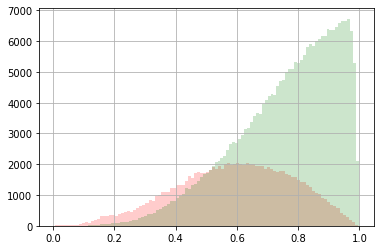

In [106]:
w_df = df2[df2["part"] == 2]
w_df[w_df["target"]==0]["predict"].hist(bins=100, alpha=0.2, color="red")
w_df[w_df["target"]==1]["predict"].hist(bins=100, alpha=0.2, color="green")

In [108]:
w_df["user_answer"].value_counts()

0    125423
3    119179
1    112083
Name: user_answer, dtype: int64

# part5

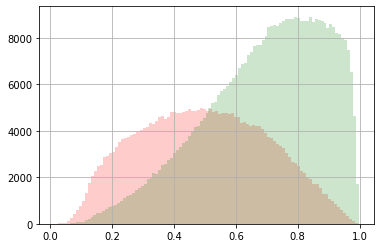

In [109]:
w_df = df2[df2["part"] == 5]
w_df[w_df["target"]==0]["predict"].hist(bins=100, alpha=0.2, color="red")
w_df[w_df["target"]==1]["predict"].hist(bins=100, alpha=0.2, color="green")

In [110]:
w_df["user_answer"].value_counts()

0    211040
1    209349
3    188802
2    166523
Name: user_answer, dtype: int64

# part7

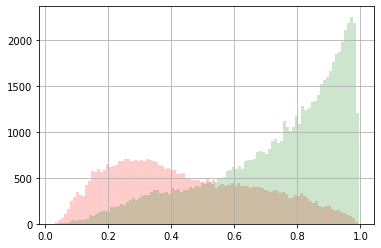

In [105]:
w_df = df2[df2["part"] == 7]
w_df[w_df["target"]==0]["predict"].hist(bins=100, alpha=0.2, color="red")
w_df[w_df["target"]==1]["predict"].hist(bins=100, alpha=0.2, color="green")

In [122]:
df2["pay_money"] = (df2["part"] != 2).astype("int") * (df2["part"] != 5).astype("int")

In [123]:
df2["user_pay_money"] = (df2.groupby("user_id")["pay_money"].cumsum() > 0).astype("int")

In [126]:
w_df = df2[df2["user_pay_money"] == 0]
print(f"n={len(w_df)}: auc={round(roc_auc_score(w_df['target'].values, w_df['predict'].values), 4)}")
w_df = df2[df2["user_pay_money"] == 1]
print(f"n={len(w_df)}: auc={round(roc_auc_score(w_df['target'].values, w_df['predict'].values), 4)}")

n=438540: auc=0.758
n=1386657: auc=0.7892


In [128]:
for part in [1, 2, 3, 4, 5, 6, 7]:
    
    w_df = df2[df2["part"] == part]
    w_df = w_df[w_df["user_pay_money"] == 1]
    print(f"part={part}, n={len(w_df)}: auc={round(roc_auc_score(w_df['target'].values, w_df['predict'].values), 4)}")

part=1, n=115860: auc=0.809
part=2, n=225000: auc=0.7567
part=3, n=150430: auc=0.8008
part=4, n=137949: auc=0.8173
part=5, n=468859: auc=0.7635
part=6, n=181319: auc=0.7977
part=7, n=107240: auc=0.8192


In [129]:
for part in [2, 5]:
    
    w_df = df2[df2["part"] == part]
    w_df = w_df[w_df["user_pay_money"] == 0]
    print(f"part={part}, n={len(w_df)}: auc={round(roc_auc_score(w_df['target'].values, w_df['predict'].values), 4)}")

part=2, n=131685: auc=0.7525
part=5, n=306855: auc=0.7543


In [133]:
df2.groupby(["user_count_50", "user_pay_money", "part"])["answered_correctly"].describe()

count      mean       std  min  25%  \
user_count_50 user_pay_money part                                           
False         0              2     106239.0  0.709673  0.453915  0.0  0.0   
                             5     244140.0  0.617089  0.486098  0.0  0.0   
              1              1      95766.0  0.761732  0.426026  0.0  1.0   
                             2     209038.0  0.710292  0.453628  0.0  0.0   
                             3     144199.0  0.713569  0.452095  0.0  0.0   
                             4     122229.0  0.681630  0.465846  0.0  0.0   
                             5     436195.0  0.619432  0.485527  0.0  0.0   
                             6     171142.0  0.676327  0.467878  0.0  0.0   
                             7      84030.0  0.675057  0.468357  0.0  0.0   
True          0              2      25446.0  0.647725  0.477689  0.0  0.0   
                             5      62715.0  0.527848  0.499228  0.0  0.0   
              1              1      20094.0  0.634518  0.481577  0.0  0.0   
                             2      15962.0  0.677923  0.467287  0.0  0.0   
                             3       6231.0  0.493179  0.499994  0.0  0.0   
                             4      15720.0  0.367875  0.482243  0.0  0.0   
                             5      32664.0  0.501623  0.500005  0.0  0.0   
                             6      10177.0  0.535128  0.498789  0.0  0.0   
                             7      23210.0  0.406549  0.491200  0.0  0.0   

                                   50%  75%  max  
user_count_50 user_pay_money part                 
False         0              2     1.0  1.0  1.0  
                             5     1.0  1.0  1.0  
              1              1     1.0  1.0  1.0  
                             2     1.0  1.0  1.0  
                             3     1.0  1.0  1.0  
                             4     1.0  1.0  1.0  
                             5     1.0  1.0  1.0  
                             6     1.0  1.0  1.0  
                             7     1.0  1.0  1.0  
True          0              2     1.0  1.0  1.0  
                             5     1.0  1.0  1.0  
              1              1     1.0  1.0  1.0  
                             2     1.0  1.0  1.0  
                             3     0.0  1.0  1.0  
                             4     0.0  1.0  1.0  
                             5     1.0  1.0  1.0  
                             6     1.0  1.0  1.0  
                             7     0.0  1.0  1.0

In [134]:
def tags(df):
    tag = df["tags"].str.split(" ", n=10, expand=True)
    tag.columns = [f"tags{i}" for i in range(1, len(tag.columns) + 1)]

    for col in ["tags1", "tags2", "tags3", "tags4", "tags5", "tags6"]:
        if col in tag.columns:
            df[col] = pd.to_numeric(tag[col], errors='coerce').fillna(-1).astype("int16")
        else:
            df[col] = -1
            df[col].astype("int16")

In [136]:
tags(df2)

# part5

In [138]:
for tag in [8, 73, 53, 1, 96, 55]:
    w_df = df2[df2["part"] == 5]
    w_df = w_df[w_df["tags1"] == tag]
    print(f"part={part}, n={len(w_df)}: auc={round(roc_auc_score(w_df['target'].values, w_df['predict'].values), 4)}")

part=5, n=30010: auc=0.7657
part=5, n=45175: auc=0.7875
part=5, n=39449: auc=0.7962
part=5, n=33558: auc=0.7819
part=5, n=30552: auc=0.7893
part=5, n=22671: auc=0.759
